In [1]:
library(dplyr)
library(ggplot2)
library(tidyr)
library(ggrepel)
library(EnhancedVolcano)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Registered S3 methods overwritten by 'ggalt':
  method                  from   
  grid.draw.absoluteGrob  ggplot2
  grobHeight.absoluteGrob ggplot2
  grobWidth.absoluteGrob  ggplot2
  grobX.absoluteGrob      ggplot2
  grobY.absoluteGrob      ggplot2



In [14]:
# root
ROOT = '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/'

# read in the data
# df = pd.read_csv('Excitatory_C9ALSvsCTRL/gene.txt', sep='\t')
df = read.table(paste0(ROOT, 'Excitatory_C9ALSvsCTRL/gene.txt'), sep='\t', header=T)
head(df)

,gene,npas,pval,RLDu,RLDi,REDu,REDu.pval,REDi,REDi.pval,nread.c1.1,nread.c1.2,nread.c1.3,nread.c1.4,nread.c1.5,nread.c2.1,nread.c2.2,nread.c2.3,nread.c2.4,nread.c2.5
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,B3GALT6,2,2.14e-06,1.6000,NA,2.720,6.07e-07,NA,NA,0,72,0,0,0,0,0,0,63,0
2,PUSL1,4,1.30e-01,0.2120,NA,0.964,1.22e-02,NA,NA,37,193,0,0,88,79,0,40,125,0
3,MIB2,2,3.96e-03,NA,0.917,NA,NA,0.917,1.15e-03,61,315,0,0,327,467,75,384,931,0
4,PRKCZ,4,3.76e-03,-0.3340,0.641,-0.564,1.61e-02,0.836,2.51e-08,170,589,0,105,491,488,57,446,848,29
5,SKI,5,3.94e-01,-0.1430,-0.228,-0.556,5.31e-02,0.177,6.46e-01,34,150,0,34,162,293,34,126,220,0
6,RER1,4,3.31e-02,0.0744,0.464,0.748,1.88e-02,0.908,1.78e-03,80,376,0,0,165,170,0,74,290,0


In [15]:
# Threshold for significance
threshold <- 0.05

# Add a significance column based on p-value
df$significant <- ifelse(df$REDu.pval < threshold, "Significant", "Not Significant")

# Further categorize based on log2FC
df$significant <- ifelse(df$significant == "Significant" & abs(df$REDu) > 1, "Highly Significant", df$significant)

# Add a category for lengthened and shortened
df$transcript_length <- ifelse(df$REDu > 0, "Shortened", "Lengthened")

df$neglog10pval <- -log10(df$REDu.pval)

In [6]:
df %>% filter(gene=='TARDBP')

gene,npas,pval,RLDu,RLDi,REDu,REDu.pval,REDi,REDi.pval,nread.c1.1,⋯,nread.c1.4,nread.c1.5,nread.c2.1,nread.c2.2,nread.c2.3,nread.c2.4,nread.c2.5,significant,transcript_length,neglog10pval
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<chr>,<chr>,<dbl>
TARDBP,7,1.16e-35,0.0683,NA,-2.52,3.88e-31,NA,NA,139,⋯,50,587,642,68,387,1070,0,Highly Significant,Lengthened,30.41117


In [12]:
library(ggplot2)
library(dplyr)
library(ggrepel)

volcano_plot_func <- function(df) {
  
  # Threshold for significance
  threshold <- 0.05

  # Filter out rows where -log10pval is greater than 50 and where REDu is less than -5 or more than 5
  df <- df[!df$neglog10pval > 50 & df$REDu > -5 & df$REDu < 5,]

  # Add a significance column based on p-value
  df$significant <- ifelse(df$REDu.pval < threshold, "Significant", "Not Significant")

  # Further categorize based on log2FC
  df$significant <- ifelse(df$significant == "Significant" & abs(df$REDu) > 1, "Significant", "Not Significant")

  # Add a category for lengthened and shortened
  df$transcript_length <- ifelse(df$REDu > 0 & df$significant == "Significant", "Shortened", 
                                 ifelse(df$REDu < 0 & df$significant == "Significant", "Lengthened", "Not Significant"))

  # ALS genes to include in the plot
  ALSgenes <- c("TARDBP","C9orf72","SOD1","FUS","NEK1","OPTN","CHCHD10","SQSTM1",
  "TBK1","KIF5A","SETX","UBQLN2","MATR3","VAPB","SIGMAR1","ANXA11",
  "TUBA4A","ALS2","GRN","PFN1","CHMP2B","TIA1","ANG","SPAST","FIG4",
  "SPG11","GLE1","CCNF","ATXN2","VCP")
  
  # Create a subset of df for top 100 most significant genes and include ALS genes
  top100 <- df[df$gene %in% ALSgenes | order(abs(df$REDu), decreasing=T),] %>% head(100)
  top100 <- rbind(top100, df[df$gene %in% ALSgenes,])
  # only keep unique genes
  top100 <- top100[!duplicated(top100$gene),]
  # remove the NA from df based on REDu
  df <- df[!is.na(df$REDu),]

  # Plot the volcano plot
  volcano_plot <- ggplot(df, aes(x=-1*REDu, y=neglog10pval, color=transcript_length)) +
      geom_point(alpha=1, size=2) + 
      scale_color_manual(values=c("#CC79A7", "grey", "#F0E442"), labels=c("Lengthened", "Not Significant", "Shortened"), name = "Transcript Length") +
      theme_bw(base_size = 14) +  
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.position = "bottom",
            legend.box = "vertical",
            legend.title = element_text(size = 14, face='bold' ),  # Adjust legend text size here
            legend.text = element_text(size = 12),  # Adjust legend text size here
            plot.title = element_text(hjust = 0.5)) +
            guides(color=guide_legend(override.aes=list(size=6))) +
      xlab('REDu') + 
      ylab('-log10pval') + 
      geom_text_repel(data = top100, aes(label = gene), size = 3.5, color='black') + 
      geom_vline(xintercept = c(-1, 1), linetype = "dashed", color = "grey", alpha = 0.8) +
      geom_hline(yintercept = -log10(threshold), linetype = "dashed", color = "grey", alpha = 0.8) +
      coord_cartesian(xlim = c(-7, 7), ylim=c(0,50)) # restrict x-axis and y-axis limits

  return(volcano_plot)
}


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 82 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


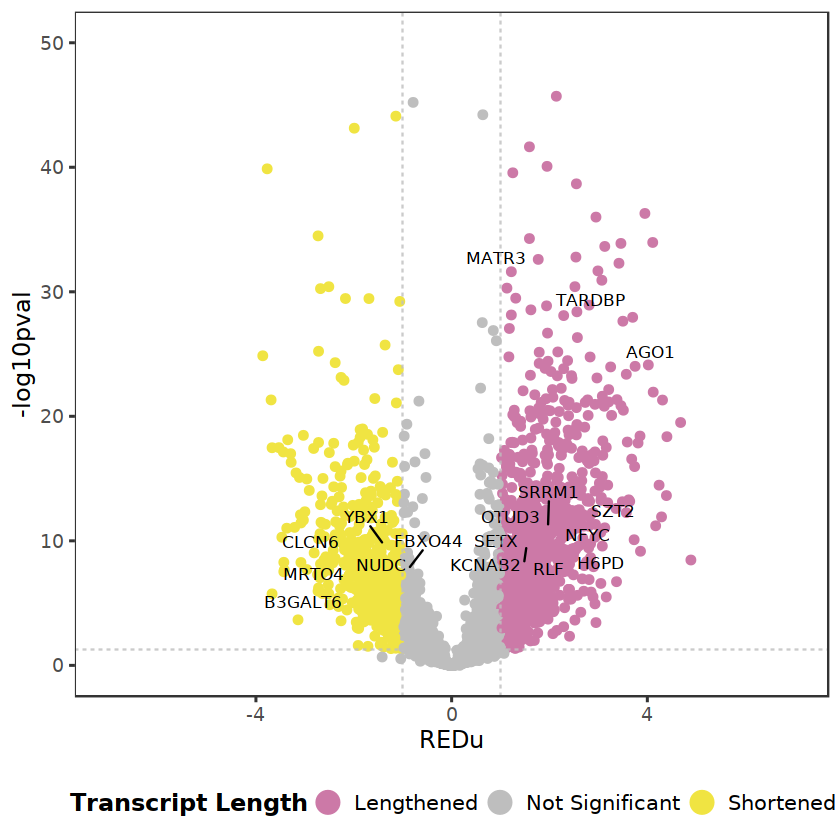

In [16]:
# You can call this function by:
plot <- volcano_plot_func(df)
print(plot)

In [8]:
# List all directories under the root
all_dirs <- list.dirs(ROOT, recursive = FALSE)

# Define the target substrings
targets <- c('Excitatory', 'Inhibitory', 'Astrocytes', 'Oligodendrocytes', 'Microglia', 'OPC')

# Function to check if any of the targets is in the name of a directory
dir_has_target <- function(dir, targets) {
  for(target in targets) {
    if(grepl(target, dir)) {
      return(TRUE)
    }
  }
  return(FALSE)
}

# Filter directories that contain any of the targets in their name
target_dirs <- all_dirs[sapply(all_dirs, dir_has_target, targets=targets)]

# Print the directories
print(target_dirs)


 [1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Astrocytes_C9ALSvsCTRL"      
 [2] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Astrocytes_sALSvsCTRL"       
 [3] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Excitatory_C9ALSvsCTRL"      
 [4] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Excitatory_sALSvsCTRL"       
 [5] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Inhibitory_C9ALSvsCTRL"      
 [6] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Inhibitory_sALSvsCTRL"       
 [7] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Microglia_C9ALSvsCTRL"       
 [8] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Microglia_sALSvsCTRL"        
 [9] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Oligodendrocytes_C9ALSvsCTRL"
[10] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Map

In [17]:
# for each directory, read in the gene.txt file and plot the volcano plot and save in pdf with ggsave command width = 8, height = 11, dpi = 300)
plot_root <- '/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/plots/'
for(dir in target_dirs) {
  print(dir)
  df <- read.table(paste0(dir, '/gene.txt'), sep='\t', header=T)
  # Add a significance column based on p-value
  df$significant <- ifelse(df$REDu.pval < threshold, "Significant", "Not Significant")
  # Further categorize based on log2FC
  df$significant <- ifelse(df$significant == "Significant" & abs(df$REDu) > 1, "Highly Significant", df$significant)
  # Add a category for lengthened and shortened
  df$transcript_length <- ifelse(df$REDu > 0, "Shortened", "Lengthened")
  df$neglog10pval <- -log10(df$REDu.pval)

  plot <- volcano_plot_func(df)
  # plot_root + name of CT + _volcano_plot.pdf
  ggsave(paste0(plot_root, gsub('.*/', '', dir), '_volcano_plot.pdf'), plot, width = 8, height = 8, dpi = 300)
}

[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Astrocytes_C9ALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 81 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Astrocytes_sALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 67 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Excitatory_C9ALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 72 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Excitatory_sALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 68 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Inhibitory_C9ALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 70 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Inhibitory_sALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 63 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Microglia_C9ALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 51 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Microglia_sALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 62 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Oligodendrocytes_C9ALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 60 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//Oligodendrocytes_sALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 56 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//OPC_C9ALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 69 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


[1] "/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs//OPC_sALSvsCTRL"


Warning message:
“Removed 1 rows containing missing values (geom_text_repel).”
Warning message:
“ggrepel: 66 unlabeled data points (too many overlaps). Consider increasing max.overlaps”


In [52]:
tst_df = read.csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/APAlog_res_metadata_added_adj_pval.tsv', sep='\t')
print(dim(tst_df))
head(tst_df)

[1] 41179    20


,transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name,sig_LFC_PA_Usage,fdr_p_ConditionALS_pathology,sig_LFC_PA_Usage_2
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>,<dbl>,<dbl>
1,AACS,0.0061454316,0.019491914,chr12:125124284:+,chr12:125140928:+,0.2612155,4.734204e-02,0.98335531,3.376034e-07,+,1,0.98335531,6.4715932,16644,"chr12,125124284,125140928",1,chr12:AACS:125124284:125140928:+,0.9833553,2.020566e-06,0.9833553
2,AACS,0.0061454316,0.019491914,chr12:125124284:+,chr12:125143316:+,1.6417462,4.866807e-52,0.26318201,1.246049e-01,+,1,0.26318201,0.9044649,19032,"chr12,125124284,125143316",1,chr12:AACS:125124284:125143316:+,0.0000000,1.805432e-01,0.0000000
3,AACS,0.0061454316,0.019491914,chr12:125140928:+,chr12:125143316:+,1.3805307,8.547748e-46,-0.72017330,1.476861e-08,+,1,-0.72017330,7.8306605,2388,"chr12,125140928,125143316",1,chr12:AACS:125140928:125143316:+,-0.7201733,1.201832e-07,-0.7201733
4,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67201672:-,0.9367987,7.468705e-06,-0.04372629,8.609305e-01,-,-1,0.04372629,0.0650319,644,"chr15,67201028,67201672",1,chr15:AAGAB:67201028:67201672:-,0.0000000,8.927807e-01,0.0000000
5,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67202710:-,1.4704390,7.400884e-14,-1.33759094,1.070773e-07,-,-1,1.33759094,6.9703026,1682,"chr15,67201028,67202710",1,chr15:AAGAB:67201028:67202710:-,1.3375909,7.195042e-07,1.3375909
6,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67217079:-,1.0982487,8.045112e-08,-1.22633047,3.590218e-06,-,-1,1.22633047,5.4448792,16051,"chr15,67201028,67217079",1,chr15:AAGAB:67201028:67217079:-,1.2263305,1.698270e-05,1.2263305


In [1]:
df = read.csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/APAlog_res_metadata_added.tsv', sep='\t')
head(df)

,transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name,sig_LFC_PA_Usage
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>
1,AACS,0.0061454316,0.019491914,chr12:125124284:+,chr12:125140928:+,0.2612155,4.734204e-02,0.98335531,3.376034e-07,+,1,0.98335531,6.4715932,16644,"chr12,125124284,125140928",1,chr12:AACS:125124284:125140928:+,0.9833553
2,AACS,0.0061454316,0.019491914,chr12:125124284:+,chr12:125143316:+,1.6417462,4.866807e-52,0.26318201,1.246049e-01,+,1,0.26318201,0.9044649,19032,"chr12,125124284,125143316",1,chr12:AACS:125124284:125143316:+,0.0000000
3,AACS,0.0061454316,0.019491914,chr12:125140928:+,chr12:125143316:+,1.3805307,8.547748e-46,-0.72017330,1.476861e-08,+,1,-0.72017330,7.8306605,2388,"chr12,125140928,125143316",1,chr12:AACS:125140928:125143316:+,-0.7201733
4,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67201672:-,0.9367987,7.468705e-06,-0.04372629,8.609305e-01,-,-1,0.04372629,0.0650319,644,"chr15,67201028,67201672",1,chr15:AAGAB:67201028:67201672:-,0.0000000
5,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67202710:-,1.4704390,7.400884e-14,-1.33759094,1.070773e-07,-,-1,1.33759094,6.9703026,1682,"chr15,67201028,67202710",1,chr15:AAGAB:67201028:67202710:-,1.3375909
6,AAGAB,0.0002527658,0.001115455,chr15:67201028:-,chr15:67217079:-,1.0982487,8.045112e-08,-1.22633047,3.590218e-06,-,-1,1.22633047,5.4448792,16051,"chr15,67201028,67217079",1,chr15:AAGAB:67201028:67217079:-,1.2263305


In [54]:
dim(df)

[1] 41179    18

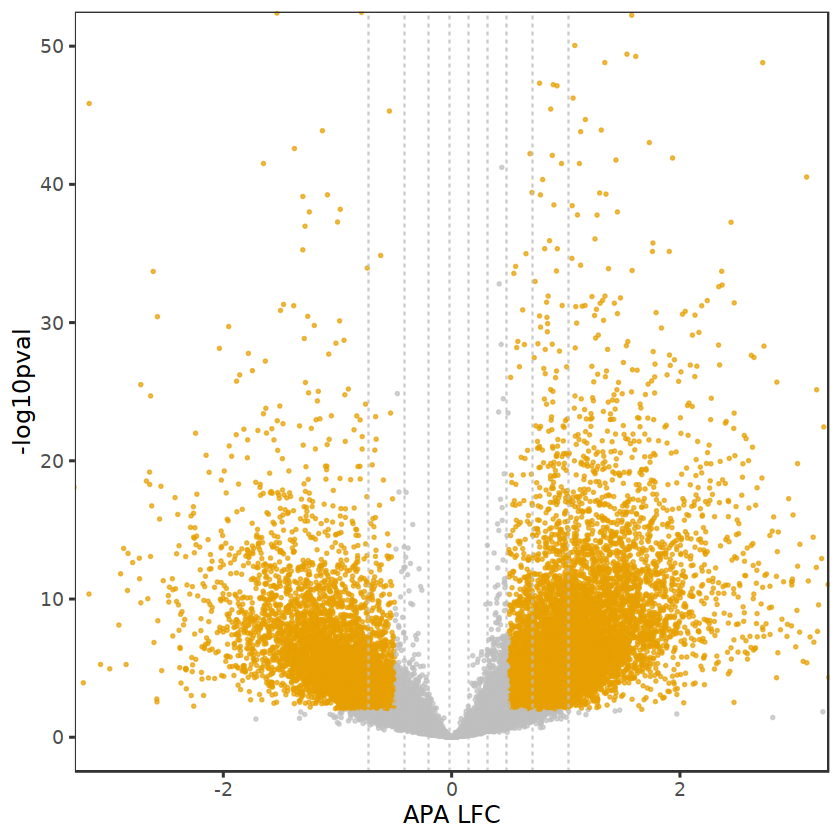

In [68]:
df = read.csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/APAlog_res_metadata_added_adj_pval.tsv', sep='\t')
# Threshold for significance
threshold <- 0.01
# Add a significance column based on p-value
df$significant <- ifelse(df$fdr_p_ConditionALS_pathology < threshold, "Significant APA", "Not Significant")

# Further categorize based on log2FC
df$significant <- ifelse(df$significant == "Significant APA" & abs(df$LFC_PA_Usage) > 0.5, "Significant APA", "Not Significant")

# # Add a category for lengthened and shortened
# df$transcript_length <- ifelse(df$LFC_PA_Usage > 0 & df$significant == "Significant", "Significant APA", 
#                                 ifelse(df$LFC_PA_Usage < 0 & df$significant == "Significant", "Significant APA", "Not Significant"))

df$neglog10pval <- -log10(df$fdr_p_ConditionALS_pathology)
# remove the NA from df based on REDu
df <- df[!is.na(df$LFC_PA_Usage),]
percentiles <- quantile(df$LFC_PA_Usage, probs = seq(0.1, 0.9, by = 0.1))

  # Plot the volcano plot
  volcano_plot <- ggplot(df, aes(x=LFC_PA_Usage, y=neglog10pval, color=significant)) +
      geom_point(alpha=.7, size=0.5) + 
      scale_color_manual(values=c("grey", "#E69F00"), name=NULL) +
      theme_bw(base_size = 14) +  
      # no legened
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.position = "none",
            legend.title = element_text(size = 14, face='bold' ),
            plot.title = element_text(hjust = 0.5)) +
      xlab('APA LFC') + 
      ylab('-log10pval') + 
      geom_vline(xintercept = percentiles, linetype = "dashed", color = "grey", alpha = 0.8) +
      coord_cartesian(xlim = c(-3, 3), ylim=c(0,50)) # restrict x-axis and y-axis limits

  return(volcano_plot)

# save pdf
ggsave("/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/plots/Exc_c9hnrnpc_volcano_plot.pdf", volcano_plot, width = 10, height = 10, units = "cm")

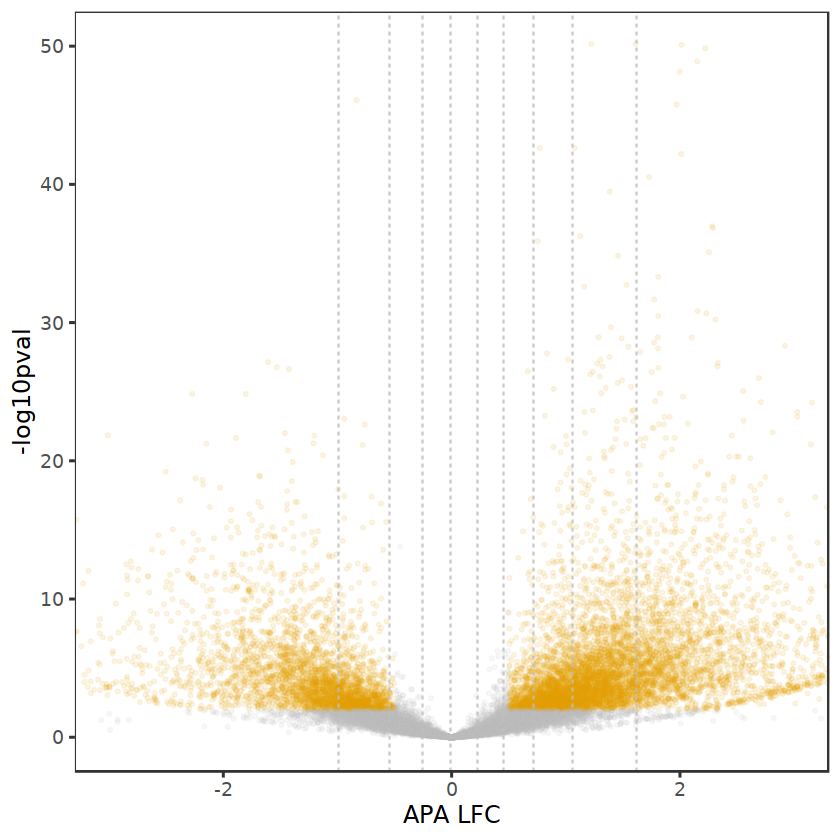

In [66]:
df = read.csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_sALSvsCTRL/APAlog_res_metadata_added_adj_pval.tsv', sep='\t')
# Threshold for significance
threshold <- 0.01
# Add a significance column based on p-value
df$significant <- ifelse(df$fdr_p_ConditionALS_pathology < threshold, "Significant APA", "Not Significant")

# Further categorize based on log2FC
df$significant <- ifelse(df$significant == "Significant APA" & abs(df$LFC_PA_Usage) > 0.5, "Significant APA", "Not Significant")

# # Add a category for lengthened and shortened
# df$transcript_length <- ifelse(df$LFC_PA_Usage > 0 & df$significant == "Significant", "Significant APA", 
#                                 ifelse(df$LFC_PA_Usage < 0 & df$significant == "Significant", "Significant APA", "Not Significant"))

df$neglog10pval <- -log10(df$fdr_p_ConditionALS_pathology)
# remove the NA from df based on REDu
df <- df[!is.na(df$LFC_PA_Usage),]
percentiles <- quantile(df$LFC_PA_Usage, probs = seq(0.1, 0.9, by = 0.1))

  # Plot the volcano plot
  volcano_plot <- ggplot(df, aes(x=LFC_PA_Usage, y=neglog10pval, color=significant)) +
      geom_point(alpha=0.1, size=.7) + 
      scale_color_manual(values=c("grey", "#E69F00"), name=NULL) +
      theme_bw(base_size = 14) +  
      # no legened
      theme(panel.grid.major = element_blank(),
            panel.grid.minor = element_blank(),
            legend.position = "none",
            legend.title = element_text(size = 14, face='bold' ),
            plot.title = element_text(hjust = 0.5)) +
      xlab('APA LFC') + 
      ylab('-log10pval') + 
      geom_vline(xintercept = percentiles, linetype = "dashed", color = "grey", alpha = 0.8) +
      coord_cartesian(xlim = c(-3, 3), ylim=c(0,50)) # restrict x-axis and y-axis limits

  return(volcano_plot)
  ggsave("/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/results/plots/Exc_sALS_hnrnpc_volcano_plot.pdf", volcano_plot, width = 10, height = 10, units = "cm")


In [13]:
df %>% filter(transcript=='TAFII68')

transcript,p_devtest,fdr_p_devtest,ref_site,alt_site,b_intercept,p_intercept,b_ConditionALS_pathology,p_ConditionALS_pathology,strand,multiplyer,LFC_PA_Usage,negative_logFDR,switch_width,bed,correction_multiplyer,switch_name,sig_LFC_PA_Usage
<chr>,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<chr>,<int>,<dbl>,<dbl>,<int>,<chr>,<int>,<chr>,<dbl>


In [26]:
df = read.csv('/data1/APA/Paul_ALS_Data/bams_in/subscelltype_bamfiles/Mapper_outs/Excitatory_C9ALSvsCTRL/gene.txt', sep='\t')

In [27]:
df %>% filter(gene=='TAF15')

gene,npas,pval,RLDu,RLDi,REDu,REDu.pval,REDi,REDi.pval,nread.c1.1,nread.c1.2,nread.c1.3,nread.c1.4,nread.c1.5,nread.c2.1,nread.c2.2,nread.c2.3,nread.c2.4,nread.c2.5
<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
